# Cancer Diagnosis Prediction 

## Feature Selection

Approach I: 
1. Train base models - Random Forest, SVM and KNN - on all prepared features. 
2. Devide features by logical categories and apply Lasso Regression to select important features within these categories, as well as remove highly correlated between each other features. 
3. Use the models again on selected features. 

In [158]:
import pandas as pd
import numpy as np

In [159]:
pd.set_option('display.max_columns', None)

In [160]:
train = pd.read_csv('target_encoded_train.csv') 
test = pd.read_csv('target_encoded_test.csv') 

In [161]:
patient_id = test['patient_id']

train.drop(columns=['patient_id'], axis=1, inplace=True)
test.drop(columns=['patient_id'], axis=1, inplace=True)

In [162]:
train.isna().sum().sort_values(ascending=False)

patient_race                 0
education_highschool         0
unemployment_rate            0
labor_force_participation    0
education_stem_degree        0
                            ..
never_married                0
divorced                     0
married                      0
female                       0
DiagPeriodL90D               0
Length: 77, dtype: int64

In [163]:
target = train['DiagPeriodL90D']
train.drop(columns=target.name, axis=1, inplace=True) 


## Apply Lasso Regression for Feature Selection

In [164]:
# Define dictionary to group columns based on themes
column_groups = {
    'locations': ['patient_state', 'Region', 'Division'],
    'age': ['age'],
    'race': ['race'],
    'education': ['education'],
    'income': ['income'],
    'rent': ['rent'],
    'social_status': ['married', 'divorced', 'widowed'],
    'empl_status': ['labor', 'employ'],
    'home_status': ['home', 'housing'],
    'health_status': ['payer', 'veteran', 'disabled', 'insured'],
    'gender_status': ['male', 'gender'],
    'diagnosis_status': ['breast_cancer'],
    'metastatic_diagnosis_status': ['metastatic_cancer'],
    'air_quality': ['Ozone', 'PM25', 'N02']
}

# Create dictionary to store sliced dataframes
sliced_dfs = {}

# Iterate over column_groups dictionary
for group, columns in column_groups.items():
    # Filter columns based on column name patterns
    relevant_columns = [column for column in train.columns if any(col in column for col in columns)]
    # Slice dataframe based on relevant columns
    sliced_dfs[group] = train[relevant_columns]

# Access sliced dataframes using keys from column_groups dictionary
locations = sliced_dfs['locations']
age = sliced_dfs['age']
race = sliced_dfs['race']
education = sliced_dfs['education']
income = sliced_dfs['income']
rent = sliced_dfs['rent']
social_status = sliced_dfs['social_status']
empl_status = sliced_dfs['empl_status']
home_status = sliced_dfs['home_status']
health_status = sliced_dfs['health_status']
diagnosis_status = sliced_dfs['diagnosis_status']
metastatic_diagnosis_status = sliced_dfs['metastatic_diagnosis_status']
air_quality = sliced_dfs['air_quality']



In [165]:
from lasso import apply_lasso

In [166]:
important_ages= apply_lasso(age, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23436320180043563
Important Features: Index(['patient_age', 'age_30s'], dtype='object')


In [167]:
important_locs= apply_lasso(locations, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23278732970013277
Important Features: Index(['patient_state'], dtype='object')


In [168]:
important_race_info = apply_lasso(race, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23439380678045546
Important Features: Index(['patient_race'], dtype='object')


In [169]:
important_education_info = apply_lasso(education, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23472063705491003
Important Features: Index(['education_less_highschool', 'education_bachelors'], dtype='object')


In [170]:
important_income_info = apply_lasso(income, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348618173059057
Important Features: Index(['income_household_25_to_35', 'income_household_75_to_100',
       'income_individual_median'],
      dtype='object')


In [171]:
important_social_info = apply_lasso(social_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23488479137924861
Important Features: Index(['widowed'], dtype='object')


In [172]:
important_empl_info = apply_lasso(empl_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.2348721455511149
Important Features: Index(['labor_force_participation'], dtype='object')


In [173]:
important_home_info = apply_lasso(home_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23494151110930983
Important Features: Index(['home_value'], dtype='object')


In [174]:
important_health_info = apply_lasso(health_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23370006403499527
Important Features: Index(['payer_type', 'disabled', 'health_uninsured'], dtype='object')


In [175]:
important_rent_info = apply_lasso(rent, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23495126730865898
Important Features: Index(['rent_median'], dtype='object')


In [176]:
important_diagnosis_info = apply_lasso(diagnosis_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.14939180660060353
Important Features: Index(['breast_cancer_diagnosis_code'], dtype='object')


In [177]:
important_met_diagnosis_info = apply_lasso(metastatic_diagnosis_status, target)

Best Parameters for LASSO: {'lasso__alpha': 0.01}
Best MSE for LASSO: 0.23060038525615778
Important Features: Index(['metastatic_cancer_diagnosis_code'], dtype='object')


In [178]:
important_air_info = apply_lasso(air_quality, target)

Best Parameters for LASSO: {'lasso__alpha': 0.1}
Best MSE for LASSO: 0.23498375813624522
Important Features: Index([], dtype='object')


Let's create a list of features that didn't have a group. 

In [137]:
miscellaneous  = ['patient_zip3', 'population', 'density', 'poverty', 'commute_time', 'family_size', 'limited_english', 'farmer']

Now we can crate a df with features that were selected by the Lasso model, didn't have the groups or weren't specified by Lasso as important. To these features we are going to apply another selection method.

In [179]:
important_feats_train = train[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    important_met_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) +
    list(air_quality.columns)
    ]
important_feats_train

,payer_type,disabled,health_uninsured,home_value,widowed,income_household_25_to_35,income_household_75_to_100,income_individual_median,education_less_highschool,education_bachelors,patient_race,patient_state,patient_age,age_30s,rent_median,breast_cancer_diagnosis_code,metastatic_cancer_diagnosis_code,patient_zip3,population,density,poverty,commute_time,family_size,limited_english,farmer,labor_force_participation,unemployment_rate,self_employed,Ozone,PM25,N02
0,0.610440,12.871429,11.200000,2.646343e+05,4.442857,10.142857,12.742857,24563.57143,33.257143,8.357143,0.605515,0.645148,84,14.014286,1165.000000,0.781037,0.593023,924,31437.75000,1189.562500,22.542857,27.814286,3.928571,10.100000,0.000000,61.528571,8.471429,13.428571,52.237210,8.650555,18.606528
1,0.599005,8.957576,7.018182,6.776885e+05,4.651515,5.163636,12.469697,41287.27273,14.230303,23.739394,0.659142,0.645148,62,13.418182,2003.125000,0.783231,0.669078,928,39121.87879,2295.939394,10.109091,30.606061,3.622727,8.057576,0.027273,65.230303,5.103030,15.224242,42.301121,8.487175,20.113179
2,0.599005,11.253333,15.066667,2.377131e+05,4.710000,6.763333,13.560000,40399.03333,10.811667,19.678333,0.659142,0.599649,43,13.545000,1235.907407,0.760766,0.669078,760,21996.68333,626.236667,9.663333,31.394915,3.260667,3.356667,3.650847,66.428333,4.560000,13.722034,40.108207,7.642753,14.839351
3,0.599005,8.845238,4.404762,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,0.659142,0.645148,45,12.464286,2354.738095,0.774744,0.669078,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,42.070075,7.229393,15.894123
4,0.599005,15.276000,12.088000,2.498457e+05,5.406000,11.462000,12.480000,29073.18367,11.576000,13.978000,0.605515,0.623656,55,10.364000,919.743590,0.091322,0.669078,836,10886.26000,116.886000,11.224000,26.170213,3.352653,1.946000,6.890909,57.488000,4.258000,13.029545,41.356058,4.110749,11.722197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12897,0.706045,17.400000,6.300000,1.005470e+05,5.705882,10.364706,11.047059,27888.52941,12.923529,14.400000,0.659142,0.622016,50,12.705882,772.647059,0.783231,0.669078,436,19413.05882,1196.805882,23.600000,19.841176,3.039412,0.864706,0.023529,61.429412,9.135294,9.105882,38.753055,8.068682,21.140731
12898,0.599005,11.243210,3.845679,8.179491e+05,5.466667,5.148750,11.286250,52778.65000,8.916049,26.903704,0.605515,0.645148,50,13.101235,2223.445946,0.776869,0.669078,945,30153.87952,976.289157,7.837037,34.700000,3.271125,5.411250,0.416250,63.281481,5.332099,14.116250,36.469947,6.265266,10.728732
12899,0.599005,8.845238,4.404762,1.012474e+06,4.623810,4.380952,10.721429,55336.28571,5.835714,33.285714,0.605515,0.645148,61,12.464286,2354.738095,0.776869,0.647687,926,32795.32558,1896.220930,8.688095,27.561905,3.098095,5.280952,0.052381,64.430952,5.264286,18.502381,42.070075,7.229393,15.894123
12900,0.706045,10.194737,6.392105,8.708732e+05,5.186842,7.589474,10.742105,39491.78947,16.200000,24.371053,0.605515,0.579577,37,17.255263,1678.447368,0.091322,0.669078,112,71374.13158,17326.407890,18.642105,42.502632,3.412105,14.173684,0.002703,64.197368,7.184211,18.145946,37.722740,7.879795,27.496367


In [180]:
important_feats_test = test[
    important_health_info + 
    important_home_info + 
    important_social_info + 
    important_income_info + 
    important_education_info + 
    important_race_info + 
    important_locs + 
    important_ages + 
    important_rent_info + 
    important_diagnosis_info +
    important_met_diagnosis_info +
    miscellaneous + 
    list(empl_status.columns) + 
    list(air_quality.columns)
    ]

Let's check feature correlations and remove features with high correlations.

In [181]:
# Compute the correlation matrix
correlation_matrix = important_feats_train.corr()

# Set the threshold for high correlation
threshold = 0.7  # You can adjust this threshold as needed

# Find pairs of features with correlation above the threshold
high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Display pairs of features with high correlation
for pair in high_correlation_pairs:
    print(f"High correlation between {pair[0]} and {pair[1]}: {pair[2]}")

High correlation between disabled and income_household_25_to_35: 0.7231136467734144
High correlation between disabled and income_individual_median: -0.7168323413079525
High correlation between disabled and education_bachelors: -0.7473949509929
High correlation between disabled and labor_force_participation: -0.7871973905168711
High correlation between home_value and rent_median: 0.9034218318106001
High correlation between widowed and labor_force_participation: -0.7014492570225168
High correlation between income_household_25_to_35 and income_individual_median: -0.8124964068287303
High correlation between income_household_25_to_35 and education_bachelors: -0.7120724906899256
High correlation between income_household_25_to_35 and rent_median: -0.7327612295396232
High correlation between income_individual_median and education_bachelors: 0.8146836159218646
High correlation between income_individual_median and rent_median: 0.7411039816304006
High correlation between education_bachelors and r

In [182]:
lasso_cor_train = important_feats_train.drop([
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    # 'Division_Pacific', 
    'population',
    'widowed',
    ], 
    axis=1
    )

lasso_cor_test = important_feats_test.drop([
    'disabled',
    'home_value', 
    'income_household_25_to_35', 
    'education_bachelors', 
    # 'Division_Pacific', 
    'population',
    'widowed', 
    ],  
    axis=1
    )


In [183]:
import matplotlib.pyplot as plt
import seaborn as sns

In [184]:
# Extract numerical columns for correlation analysis
numerical_columns = lasso_cor_train.select_dtypes(include='number')

# Calculate correlation matrix
correlation_matrix = numerical_columns.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Apply the threshold for significance
significant_corr_mask = np.abs(correlation_matrix) > 0.6

# Combine the upper triangle mask and the significance mask
final_mask = np.logical_and(mask, significant_corr_mask)

# Set values outside the final mask to NaN
correlation_matrix[~final_mask] = np.nan

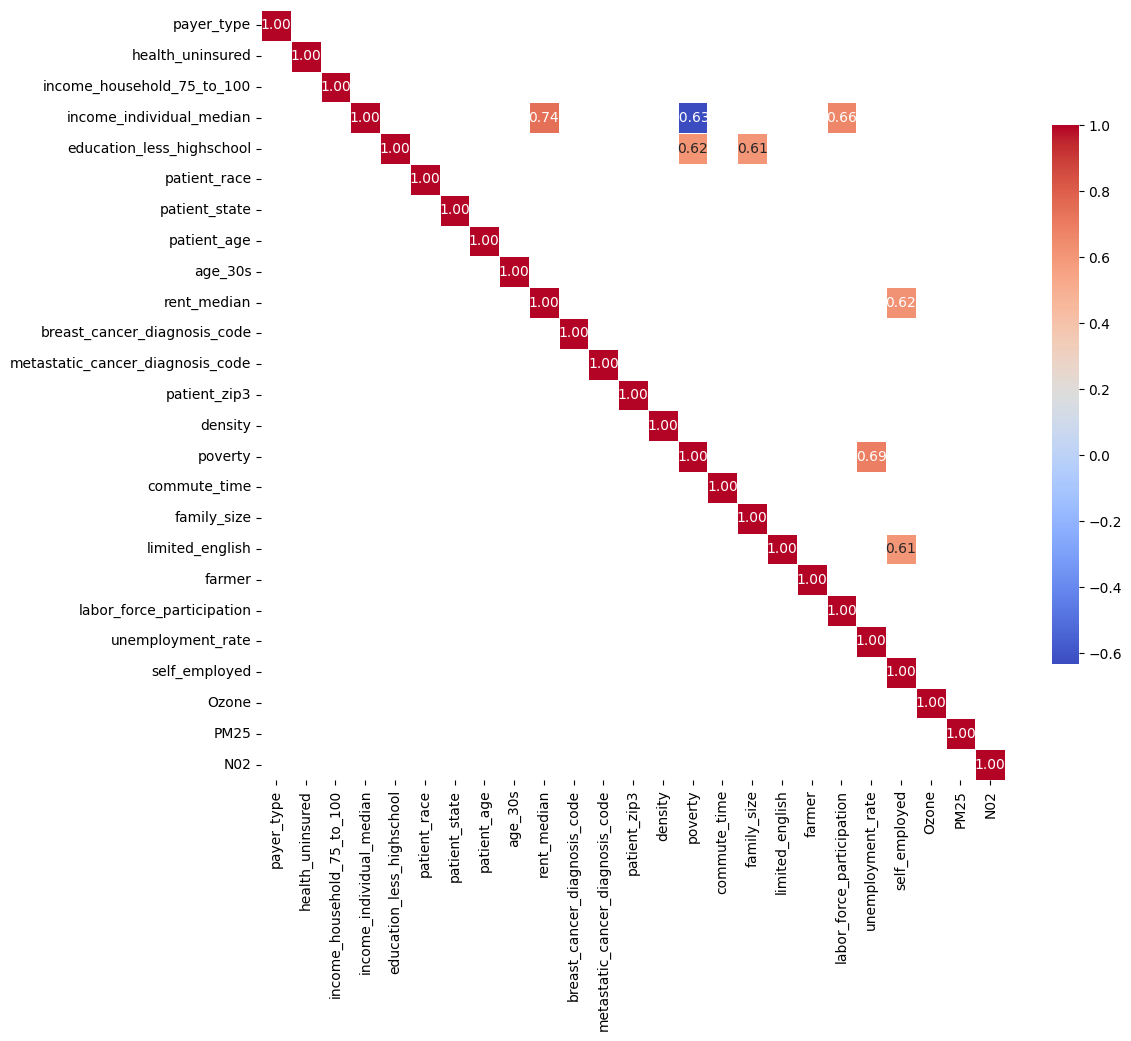

In [185]:
# Define the size of the figure
plt.figure(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={"shrink": 0.7})

# Show the plot

plt.show()

Let's split features on train and test to train the models for the baseline prediction. 

In [186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=42)

# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model to training data
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Get the indices of the top n features
n = 40  # Change this to the number of top features you want
top_feature_indices = feature_importances.argsort()[-n:][::-1]

# Get the names of the top features
top_feature_names = X_train.columns[top_feature_indices]

# Print the top features and their importances
for feature_name, importance in zip(top_feature_names, feature_importances[top_feature_indices]):
    print(f"{feature_name}: {importance}")

# Calculate ROC AUC score using cross-validation
roc_auc_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='roc_auc')

print("ROC AUC scores:", roc_auc_scores)
print("Mean ROC AUC score:", roc_auc_scores.mean())

# Evaluate on the test set
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC score on test set:", roc_auc_test)


breast_cancer_diagnosis_code: 0.3978015384057615
patient_age: 0.16803931895246518
metastatic_cancer_diagnosis_code: 0.0794167635280324
payer_type: 0.04943237573175643
patient_race: 0.04526420635860813
patient_state: 0.0049729285182582884
commute_time: 0.004687219630831839
widowed: 0.004492022611090486
Ozone: 0.004383246931458289
patient_zip3: 0.004380481273178371
income_household_75_to_100: 0.004228314675483228
age_over_80: 0.0042105620699802665
race_native: 0.0042042759886755056
age_40s: 0.004165275895646192
race_pacific: 0.004115248088454267
labor_force_participation: 0.004098752603611697
education_highschool: 0.004020785712504536
education_bachelors: 0.004019584683430661
health_uninsured: 0.004016193921026759
unemployment_rate: 0.004016189893428645
income_household_100_to_150: 0.004000363753167487
education_stem_degree: 0.00395800257924234
family_size: 0.003922894126099529
divorced: 0.0039153784434196506
veteran: 0.003909402209269674
income_household_35_to_50: 0.003883148633924351
a

In [187]:
from train_test_simple_models import train_test_models

In [147]:
# best_base_models, base_feature_importances, base_pipelines = train_test_models(train, target)

In [188]:
best_models, feature_importances, pipelines = train_test_models(lasso_cor_train, target)


Training RandomForest model with GridSearchCV...
Best Parameters for RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Best ROC for RandomForest: 0.8041986826605833

Best RandomForest Model Evaluation:
ROC AUC: 0.7908295027918381
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.55      0.68       948
           1       0.79      0.96      0.86      1633

    accuracy                           0.81      2581
   macro avg       0.83      0.76      0.77      2581
weighted avg       0.82      0.81      0.80      2581


Training SVM model with GridSearchCV...
Best Parameters for SVM: {'classifier__C': 0.1, 'classifier__gamma': 0.001}
Best ROC for SVM: 0.7923392346193185

Best SVM Model Evaluation:
ROC AUC: 0.7824488206066338
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.56      0.68       948
           1       0.79      0.96      0.87      1

In [189]:
def feature_importance(feature_importances_dict):
    # Display feature importances
    for name, feature_importances in feature_importances_dict.items():
        print(f"\nFeature Importances for {name} model:")
        if feature_importances:
            for feature, importance in sorted(feature_importances.items(), key=lambda x: x[1], reverse=True):
                print(f"{feature}: {importance}")
        else:
            print(f"No feature importances available for {name} model.")


In [190]:
# feature_importance(base_feature_importances)

In [191]:
feature_importance(feature_importances)


Feature Importances for RandomForest model:
breast_cancer_diagnosis_code: 0.6710367211983231
patient_age: 0.05616571049180028
metastatic_cancer_diagnosis_code: 0.04157139671400754
payer_type: 0.01480735761237983
patient_state: 0.01263309690201596
patient_zip3: 0.011761871780672272
labor_force_participation: 0.011611226167749478
commute_time: 0.011310772601608836
Ozone: 0.011287685125500282
health_uninsured: 0.011123917702017008
unemployment_rate: 0.010919803466699017
income_household_75_to_100: 0.010739280907665714
self_employed: 0.010488951065072619
PM25: 0.010439913201969634
age_30s: 0.010321386268013027
education_less_highschool: 0.010175264110239501
rent_median: 0.009698981487958032
density: 0.009684317414538192
limited_english: 0.009551607700303893
poverty: 0.009451017526813833
family_size: 0.009389917908921455
N02: 0.009388811763294884
income_individual_median: 0.008992423823761487
patient_race: 0.008910648228917514
farmer: 0.008537918829756541

Feature Importances for SVM model

In [192]:
def predict_test_set(pipelines, best_models, test, patient_id):
    """
    Predict the target variable using the provided models on the test set.
    
    Parameters:
        pipelines (dict): Dictionary containing the pipelines for each model.
        best_models (dict): Dictionary containing the best models for each classifier.
        test (pd.DataFrame): Test dataset.
        patient_id (pd.Series): Series containing patient IDs.
        
    Returns:
        predictions (dict): Dictionary containing the predicted values for each model.
    """
    predictions = {}
    for name, model in best_models.items():
        y_pred = model.predict(test)
        predictions[name] = y_pred

    # Insert patient_id to RandomForest predictions
    predictions['RandomForest'] = pd.DataFrame(predictions['RandomForest'], columns=['DiagPeriodL90D'])
    predictions['RandomForest'].insert(0, 'patient_id', patient_id)

    predictions['SVM'] = pd.DataFrame(predictions['SVM'], columns=['DiagPeriodL90D'])
    predictions['SVM'].insert(0, 'patient_id', patient_id)

    predictions['KNN'] = pd.DataFrame(predictions['SVM'], columns=['DiagPeriodL90D'])
    predictions['KNN'].insert(0, 'patient_id', patient_id)

    return predictions['RandomForest'], predictions['SVM'], predictions['KNN']

RandomForest_result, SVM_result, KNN_result = predict_test_set(pipelines, best_models, lasso_cor_test, patient_id)


In [193]:
len(feature_importances['RandomForest'].keys())

25

In [194]:
forest_imp_feats = pd.DataFrame(feature_importances['RandomForest'].keys(), columns=['imp_features'])
forest_imp_feats.to_csv('forest_imp_feats.csv', index=False)

In [195]:
RandomForest_result.to_csv('forest_result.csv', index=False)
SVM_result.to_csv('svm_result.csv', index=False)
KNN_result.to_csv('knn_result.csv', index=False)